<a href="https://colab.research.google.com/github/Berenice2018/DeepLearning/blob/master/FER2_mz_berenice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#!pip install facenet-pytorch
# Imports here
import torch
import torch.functional as F
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch import nn, optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, models, transforms
from torchvision import datasets, transforms, models
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import json
import numpy as np
import time
import datetime
import copy
import matplotlib.pyplot as plt
%matplotlib inline
import os,cv2
from facenet_pytorch import MTCNN, InceptionResnetV1
import pandas as pd
#from pylab import rcParams
#rcParams['figure.figsize'] = 20, 10

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
fer= "./gdrive/My Drive/Colab Notebooks/Fer-dataset/fer2013/fer2013.csv"
ferr= "./gdrive/My Drive/Colab Notebooks/Fer-dataset"

!ls   '/content/gdrive/My Drive/Colab Notebooks/Fer-dataset/fer2013/'

fer2013.bib  fer2013.csv  PrivateTest  PublicTest  README  Training


In [0]:
!pip install mxnet

### Convert and save images to Gdrive

In [0]:
#! /usr/bin/env python3
# -*-coding: utf-8-*-

__author__ = 'Moonkie'

import numpy as np
import cv2
import mxnet as mx
import pandas as pd
import random
import os

curdir = os.path.abspath(os.path.dirname(fer))

def gen_record(csvfile,channel):
    data = pd.read_csv(csvfile,delimiter=',',dtype='a')
    labels = np.array(data['emotion'],np.float)
    # print(labels,'\n',data['emotion'])
        
    imagebuffer = np.array(data['pixels'])
    images = np.array([np.fromstring(image,np.uint8,sep=' ') for image in imagebuffer])
    del imagebuffer
    num_shape = int(np.sqrt(images.shape[-1]))
    images.shape = (images.shape[0],num_shape,num_shape)
    # img=images[0];cv2.imshow('test',img);cv2.waitKey(0);cv2.destroyAllWindow();exit()
    dirs = set(data['Usage'])
    subdirs = set(labels)
    class_dir = {}
    for dr in dirs:
        dest = os.path.join(curdir,dr)
        class_dir[dr] = dest
        if not os.path.exists(dest):
            os.mkdir(dest)
            
    data = zip(labels,images,data['Usage'])
    
    for d in data:
        destdir = os.path.join(class_dir[d[-1]],str(int(d[0])))
        if not os.path.exists(destdir):
            os.mkdir(destdir)
        img = d[1]
        filepath = unique_name(destdir,d[-1])
        print('[^_^] Write image to %s' % filepath)
        if not filepath:
            continue
        sig = cv2.imwrite(filepath,img)
        if not sig:
            print('Error')
            exit(-1)


def unique_name(pardir,prefix,suffix='jpg'):
    filename = '{0}_{1}.{2}'.format(prefix,random.randint(1,10**8),suffix)
    filepath = os.path.join(pardir,filename)
    if not os.path.exists(filepath):
        return filepath
    unique_name(pardir,prefix,suffix)
    


if __name__ == '__main__':
    filename = 'fer2013.csv'
    filename = os.path.join(curdir,filename)
    gen_record(filename,1)
    
    # ##################### test
    # tmp = unique_name('./Training','Training')
    # print(tmp)

### Load data , image transform

In [5]:
data_dir = "./gdrive/My Drive/Colab Notebooks/Fer-dataset/fer2013"
train_dir = data_dir + '/Training'
valid_dir = data_dir + '/PublicTest'
test_dir = data_dir + '/PrivateTest'

# original img size = 48 x48 px
# TODO: Define your transforms for the training and validation sets
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(), #  BC changed from VerticalFlip to horiz. flip
        #transforms.RandomResizedCrop(256), # BC changed the order of Crop and Resize to 160
        #transforms.Resize(224),
        transforms.Resize(160),  # 160x160 for InceptionResnetV1
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        #transforms.CenterCrop(256),
        #transforms.Resize(224),
        transforms.Resize(160),  # 160x160 for InceptionResnetV1
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        #transforms.CenterCrop(224),
        transforms.Resize(160),#160x160
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ])
    }

# TODO: Load the datasets with ImageFolder

dirs = {'train': train_dir, 
        'valid': valid_dir,
        'test': test_dir}

datasets = {x: torchvision.datasets.ImageFolder(dirs[x],   transform=data_transforms[x]) for x in ['train', 'valid', 'test']}

# TODO: Using the image datasets and the trainforms, define the dataloaders

dataloaders = {x: torch.utils.data.DataLoader(datasets[x], batch_size=32, shuffle=True, num_workers=7) for x in ['train', 'valid','test']}

dataset_sizes = {x: len(datasets[x]) 
                              for x in ['train', 'valid','test']}
print(dataset_sizes)

{'train': 32556, 'valid': 3589, 'test': 3589}


In [6]:
class_names = datasets['train'].classes
print(class_names)

['0', '1', '2', '3', '4', '5', '6']


### Show some sample images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

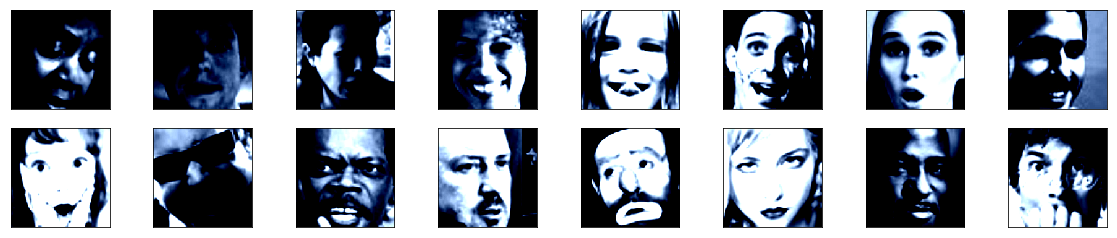

In [9]:
# get a batch of training images
dataiter = iter(dataloaders['train'])
images, _ = dataiter.next()
images = images.numpy() # convert images to numpy

# plot the images of the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))

for idx in np.arange(16):
    ax = fig.add_subplot(2, 16/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))  # convert from Tensor image

### Model train helper

In [0]:
def get_time():
      hour = datetime.datetime.today().hour +2
      minute = datetime.datetime.today().minute
      second = datetime.datetime.today().second
      return hour, minute, second

In [0]:
def train_model(model, name, criteria, optimizer, scheduler = None, epochs=50, device='cuda'):
    h, m, s = get_time()
    print('starting the training at {}:{}:{}'.format(h, m, s))
    since = time.time()
    best_model = copy.deepcopy(model.state_dict())
    
    # initialize tracker for accuracy 
    min_loss = np.Inf
    TS_loss = pd.DataFrame(np.nan, index = range(1,epochs+1), columns = ['train loss','valid loss'])
    TS_acc = pd.DataFrame(np.nan,index = range(1,epochs+1), columns = ['train acc','valid acc'])
    
    for epoch in range(1, epochs+1):        
        # monitor loss/accuracy
        train_loss_running = 0.0
        valid_loss_running = 0.0
        train_acc_running = 0.0
        valid_acc_running = 0.0

        ###################
        # train the model #
        ###################
        if scheduler:
            scheduler.step()
        model.train() # prep model for training
        
        for data, target in dataloaders['train']:
    
            # Move input and data tensors to the default device
            data, target = data.to(device), target.to(device)
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criteria(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update training loss 
            train_loss_running += loss.item()*data.size(0)
            # accuracy
            _, preds = torch.max(output, 1)
            train_acc_running  += torch.sum(preds == target.data)
            
            del loss

        ######################    
        # validate the model #
        ######################
        model.eval()
        with torch.no_grad():
            for data, target in dataloaders['valid']:
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = criteria(output, target)
                valid_loss_running += loss.item()*data.size(0)
                
                _, preds = torch.max(output, 1)
                valid_acc_running  += torch.sum(preds == target.data)
                
                del loss
                # Calculate accuracy
                #ps = torch.exp(logps)
                #top_p, top_class = ps.topk(1, dim=1)
                #equals = top_class == labels.view(*top_class.shape)
                #accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

        # statistics
        train_loss = train_loss_running/ dataset_sizes['train']
        valid_loss = valid_loss_running/ dataset_sizes['valid']
        train_acc = train_acc_running.double()/ dataset_sizes['train']
        valid_acc = valid_acc_running.double()/ dataset_sizes['valid']
        
        TS_loss.loc[epoch] = [train_loss, valid_loss]
        TS_acc.loc[epoch] = [(train_acc.cpu().numpy()), (valid_acc.cpu().numpy())]                                         

        # print training/validation statistics 
        hour, minute, second = get_time()
        print('Epoch: {} at {}:{}:{} \tTrain. Loss: {:.6f} \tValid. Loss: {:.6f} \t Accur.: {:.10f}'.format(
                  epoch,
                  hour, minute, second,
                  train_loss,
                  valid_loss,
                  valid_acc 
        ))
                                                             
        # save model if validation acc has increased
        # BC: using the lower validation loss as criterium, when saving a model
        if valid_loss <= min_loss:
            old_loss_min = min_loss
            min_loss = valid_loss
            save = True
            
            print('*** Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            old_loss_min, min_loss))        
    
    #End
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    #print('Best Valid Acc: {:4f}'.format(best_acc))
                                                   
    TS_loss.plot(title = 'loss')
    TS_acc.plot(title = 'acc')
                                                   
    # load best model weights
    model.load_state_dict(best_model)
    torch.save(model.state_dict(), name)
    
    return model

### Hyper params, start training

In [0]:
from facenet_pytorch import MTCNN, InceptionResnetV1
# https://github.com/timesler/facenet-pytorch

# create a face detection pipeline using MTCNN:
mtcnn = MTCNN()

model = InceptionResnetV1(classify=True, num_classes=7).eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device);

#model

starting the training at 21:12:15
Epoch: 1 at 21:19:11 	Train. Loss: 1.899793 	Valid. Loss: 1.891566 	 Accur.: 0.2468654221
*** Validation loss decreased (inf --> 1.891566).  Saving model ...

Epoch: 2 at 21:26:5 	Train. Loss: 1.893312 	Valid. Loss: 1.870831 	 Accur.: 0.2691557537
*** Validation loss decreased (1.891566 --> 1.870831).  Saving model ...

Epoch: 3 at 21:33:2 	Train. Loss: 1.847233 	Valid. Loss: 1.816533 	 Accur.: 0.3268319866
*** Validation loss decreased (1.870831 --> 1.816533).  Saving model ...

Epoch: 4 at 21:39:59 	Train. Loss: 1.808658 	Valid. Loss: 1.786185 	 Accur.: 0.3655614377
*** Validation loss decreased (1.816533 --> 1.786185).  Saving model ...

Epoch: 5 at 21:46:57 	Train. Loss: 1.764969 	Valid. Loss: 1.740302 	 Accur.: 0.4159933129
*** Validation loss decreased (1.786185 --> 1.740302).  Saving model ...

Epoch: 6 at 21:53:55 	Train. Loss: 1.735843 	Valid. Loss: 1.725743 	 Accur.: 0.4293675118
*** Validation loss decreased (1.740302 --> 1.725743).  Saving 

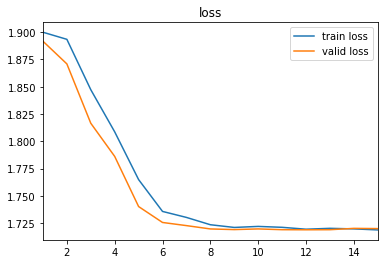

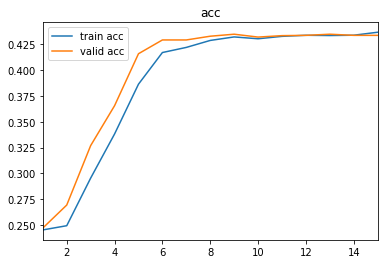

In [15]:
epochs = 15

# freezing the feature part of the pre-trained model 
for param in model.parameters():
    param.requires_grad = True

criteria = nn.CrossEntropyLoss()    
lr = 3e-2
optimizer = optim.Adam(model.parameters(), lr=lr)

stepsize = 3
scheduler = lr_scheduler.StepLR(optimizer, step_size=stepsize, gamma=0.1)



# create model name
save_path = './gdrive/My Drive/Colab Notebooks/Fer-dataset/'
modelname = '{}IncepResV1-{}-lr{}-{}{}-epo{}.pth'.format(save_path, 'Adam', lr, 'StepLR_', stepsize, epochs)

print(modelname)

model_ft = train_model(model, modelname, criteria, optimizer, scheduler, epochs, device)



### Transfer learning, unfreeze layers

In [0]:
modely = models.resnext50_32x4d(pretrained=False)
modely.load_state_dict(torch.load(modelname),strict=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_ft.to(device);

In [0]:
print(model_ft)


In [0]:
for param in model_ft.parameters():
    param.requires_grad = True

criterion_tf = nn.CrossEntropyLoss()  

lr_tf = 1e-4
optimizer_tf = optim.Adam(model_ft.parameters(), lr=lr_tf)

stepsize_tf = 10
scheduler_tf = lr_scheduler.StepLR(optimizer, step_size=stepsize_tf, gamma=0.1)

epochs_ft = 25

# create model name
save_path = './gdrive/My Drive/Colab Notebooks/Fer-dataset/'
modelname_xy = '{}tf_resnext50-{}-lr{}-{}{}-epo{}.pth'.format(
    save_path, 
    'Adam', 
    lr_tf, 
    'StepLR_', 
    stepsize_tf, 
    epochs_ft
)

print(modelname_xy)

modelxy = train_model(
    model_ft, 
    modelname_xy, 
    criterion_tf, 
    optimizer_tf, 
    scheduler_tf, 
    epochs_ft, 
    device
)

./gdrive/My Drive/Colab Notebooks/Fer-dataset/tf_resnext50-Adam-lr0.0001-StepLR_10-epo25.pth
starting the training at 24:12:37
Epoch: 1 at 24:19:34 	Train. Loss: 1.748231 	Valid. Loss: 1.717590 	 Accur.: 0.4711618835
*** Validation loss decreased (inf --> 1.717590).  Saving model ...

Epoch: 2 at 24:26:37 	Train. Loss: 1.688732 	Valid. Loss: 1.682016 	 Accur.: 0.4951239900
*** Validation loss decreased (1.717590 --> 1.682016).  Saving model ...

Epoch: 3 at 24:33:41 	Train. Loss: 1.649020 	Valid. Loss: 1.650132 	 Accur.: 0.5193647256
*** Validation loss decreased (1.682016 --> 1.650132).  Saving model ...

Epoch: 4 at 24:40:43 	Train. Loss: 1.620814 	Valid. Loss: 1.632999 	 Accur.: 0.5316244079
*** Validation loss decreased (1.650132 --> 1.632999).  Saving model ...

Epoch: 5 at 24:47:44 	Train. Loss: 1.606246 	Valid. Loss: 1.608372 	 Accur.: 0.5578155475
*** Validation loss decreased (1.632999 --> 1.608372).  Saving model ...

Epoch: 6 at 24:54:45 	Train. Loss: 1.589798 	Valid. Loss: 

### Test

In [0]:
def test(loader, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.
    
    print('test started at ', get_time())
    model.eval()
    for batch_idx, (data, target) in enumerate(loaders):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('test finished at ', get_time())
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

In [0]:

# call test function    
test(dataloaders['test'], modelxy, criterion_tf, device)

### Unused stuff ?

In [0]:
# save model as a checkpoint file after every 5 epochs
def save_model_checkpoint(model, optimizer, criteria, epochs):
  model.to('cpu')
  model.class_to_idx = datasets['train'].class_to_idx
  checkpoint = {'input_size': 48*48*1,
                'output_size': 7,
                'model': model,
                'state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'criterion': criteria,
                'epochs': epochs,
                'class_to_idx': model.class_to_idx}

  path = "/content/gdrive/My Drive/facial_expressions.pth"
  torch.save(checkpoint,path)


# load model function 
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath, map_location='cpu')
    model = checkpoint["model"]
    model.load_state_dict(checkpoint['state_dict'])
    return model

In [0]:
#! /usr/bin/env python3
# -*-coding: utf-8-*-

__author__ = 'Moonkie'

import numpy as np
import cv2
import mxnet as mx
import pandas as pd
import random
import os

curdir = os.path.abspath(os.path.dirname(fer))

def gen_record(csvfile,channel):
    data = pd.read_csv(csvfile,delimiter=',',dtype='a')
    labels = np.array(data['emotion'],np.float)
    # print(labels,'\n',data['emotion'])
        
    imagebuffer = np.array(data['pixels'])
    images = np.array([np.fromstring(image,np.uint8,sep=' ') for image in imagebuffer])
    del imagebuffer
    num_shape = int(np.sqrt(images.shape[-1]))
    images.shape = (images.shape[0],num_shape,num_shape)
    # img=images[0];cv2.imshow('test',img);cv2.waitKey(0);cv2.destroyAllWindow();exit()
    dirs = set(data['Usage'])
    subdirs = set(labels)
    class_dir = {}
    for dr in dirs:
        dest = os.path.join(curdir,dr)
        class_dir[dr] = dest
        if not os.path.exists(dest):
            os.mkdir(dest)
            
    data = zip(labels,images,data['Usage'])
    
    for d in data:
        destdir = os.path.join(class_dir[d[-1]],str(int(d[0])))
        if not os.path.exists(destdir):
            os.mkdir(destdir)
        img = d[1]
        filepath = unique_name(destdir,d[-1])
        print('[^_^] Write image to %s' % filepath)
        if not filepath:
            continue
        sig = cv2.imwrite(filepath,img)
        if not sig:
            print('Error')
            exit(-1)


def unique_name(pardir,prefix,suffix='jpg'):
    filename = '{0}_{1}.{2}'.format(prefix,random.randint(1,10**8),suffix)
    filepath = os.path.join(pardir,filename)
    if not os.path.exists(filepath):
        return filepath
    unique_name(pardir,prefix,suffix)
    


if __name__ == '__main__':
    filename = 'fer2013.csv'
    filename = os.path.join(curdir,filename)
    gen_record(filename,1)
    
    # ##################### test
    # tmp = unique_name('./Training','Training')
    # print(tmp)